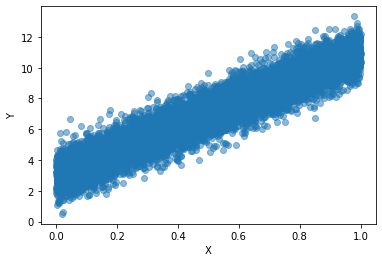

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

a = 8
b = 3

X = np.random.random(size=10000) 
Y = a * X + b + np.random.normal(scale=0.8, size=10000)
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='float32')

plt.xlabel("X")
plt.ylabel("Y")
plt.plot(X, Y, "o", alpha = 0.5)
plt.show()
plt.close()

In [3]:
# Step 1. Sequential
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mse')
model.fit(X, Y, epochs = 10)
model.summary()
model.get_weights()

Epoch 1/10
313/313 [==============================] - 3s 1ms/step - loss: 4.6165
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6738
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6467
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6462
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6476
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6475
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6485
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6491
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6510
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6524
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1

[array([[7.921265]], dtype=float32), array([3.0450165], dtype=float32)]

In [4]:
# Step 2. Model
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(1,))
outputs = tf.keras.layers.Dense(1)(inputs)
model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mse')
model.fit(X, Y, epochs = 10)
model.summary()
model.get_weights()

Epoch 1/10
313/313 [==============================] - 1s 1ms/step - loss: 5.5898
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6971
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6469
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6478
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6475
Epoch 6/10
313/313 [==============================] - 0s 2ms/step - loss: 0.6489
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6481
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6496
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6497
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6497
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]  

[array([[8.040156]], dtype=float32), array([3.028296], dtype=float32)]

In [5]:
# Step 3. Custom
tf.keras.backend.clear_session()

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(1)

  def call(self, inputs):
    outputs = self.dense1(inputs)
    return outputs

model = MyModel()
model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mse')
model.fit(X, Y, epochs = 10)
model.summary()
model.get_weights()

Epoch 1/10
313/313 [==============================] - 1s 1ms/step - loss: 2.9794
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6513
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6474
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6475
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6482
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6491
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6529
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6513
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6505
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.6513
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple  

[array([[8.119732]], dtype=float32), array([3.04064], dtype=float32)]

In [11]:
# Step 4. Gradient Tape
tf.keras.backend.clear_session()

model = MyModel()
BUFFER_SIZE = len(X)
BATCH_SIZE = 32
# from_tensor_slices: the simplest way to create a dataset using list
# shuffle: randomly shuffles the elements of this dataset
# buffer_size: for perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required
dataset = tf.data.Dataset.from_tensor_slices(([[x] for x in X], Y)).shuffle(BUFFER_SIZE)
# drop_remainder: if batch_size does not divide the number of input elements N evenly, then make sure to use drop_remainder True to prevent the smaller batch from being produced
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
optimizer_adam = tf.keras.optimizers.Adam(0.1)
loss_mse = tf.keras.losses.MeanSquaredError()

@tf.function
def train(model, dataset, optimizer):
  loss = 0.
  for x, y in dataset:
    # automatic differentiation
    with tf.GradientTape() as tape:
      prediction = model(x)
      loss = loss_mse(prediction, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
  loss = train(model, dataset, optimizer_adam)

model.get_weights()

[array([[8.102883]], dtype=float32), array([2.936888], dtype=float32)]